In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, InputLayer, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM
import tensorflow as tf

import preprocess, fit_nn

In [23]:
architecture = "LSTM_LoCap"

source_contract = "GMMB"
source_lapse = "nolapse"
source_noiseLevel = "LowNoise"
source_dataSize = 50000

target_contract = "GMMB"
target_lapse = "lapse"
target_noiseLevel = "LowNoise"
target_dataSize = 2000
test_size = 0
seed = 22
n_epochs = 1000
batch_size = 4096
patience = 50
lr = 0.00025
dropout = 0.1 
decay_rate = 0.9
layer_freeze = 2

source_model_path = f"./trainedModels/{source_contract}_PY/{source_lapse}/{architecture}_{source_noiseLevel}_{source_dataSize}/trained_model.keras"

source_model = tf.keras.models.load_model(source_model_path)

if layer_freeze > 0:
    for layer in source_model.layers[:layer_freeze]:
        layer.trainable = False
    target_model_path = f"./trainedModels/{target_contract}_PY/{target_lapse}/{architecture}_{target_noiseLevel}_{source_lapse}_{target_dataSize}_layerFreezing/"
else:
    target_model_path = f"./trainedModels/{target_contract}_PY/{target_lapse}/{architecture}_{target_noiseLevel}_{source_lapse}_{target_dataSize}_fineTuning/"

if not os.path.exists(target_model_path):
    os.makedirs(target_model_path)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                                 decay_steps=1000,
                                                                 decay_rate=decay_rate)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

source_model.compile(loss="mean_squared_error",
                     optimizer=optimizer, metrics=['mean_squared_error'])

cwd = f"../sim_VA/result/{target_contract}/{target_lapse}/"

price = np.load(cwd + f"outerScenarios_{target_contract}_RS_{target_lapse}.npy")
rtn = (price[:, 1:] - price[:, :-1]) / price[:, :-1]

substring = f"hedgingLoss_{target_contract}_RS_100_{target_lapse}"
loss_file = [file for file in os.listdir(cwd) if substring in file and os.path.isfile(os.path.join(cwd, file))][0]

X_train, y_train, X_test, y_test, y_mean, y_std = preprocess.transform_data(rtn, np.load(cwd + loss_file), True, test_size, seed,
                                                                            part=True, part_size=target_dataSize)


target_model, running_time = fit_nn.train_model(X_train, y_train, source_model, n_epochs, batch_size, patience, target_model_path)

target_model.save(target_model_path + "trained_model_1.keras")

Data is split, training and test data has shape:
(2000, 240, 1) (2000,) (2000, 240, 1) (2000,)
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.8868 - mean_squared_error: 2.8868 - val_loss: 3.6567 - val_mean_squared_error: 3.6567
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 2.7185 - mean_squared_error: 2.7185 - val_loss: 3.6078 - val_mean_squared_error: 3.6078
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 2.7395 - mean_squared_error: 2.7395 - val_loss: 3.5601 - val_mean_squared_error: 3.5601
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 2.6581 - mean_squared_error: 2.6581 - val_loss: 3.5130 - val_mean_squared_error: 3.5130
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 2.6477 - mean_squared_error: 2.6477 - val_loss: 3.4666 - val_mean_squared_error: 3.4666
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 2.5899 - mean_squared_error: 2.5899 - val_loss: 3.4214 - val_mean_squared_error: 3.4214
Epoch 7/1000
1/1 ━━━

KeyboardInterrupt: 

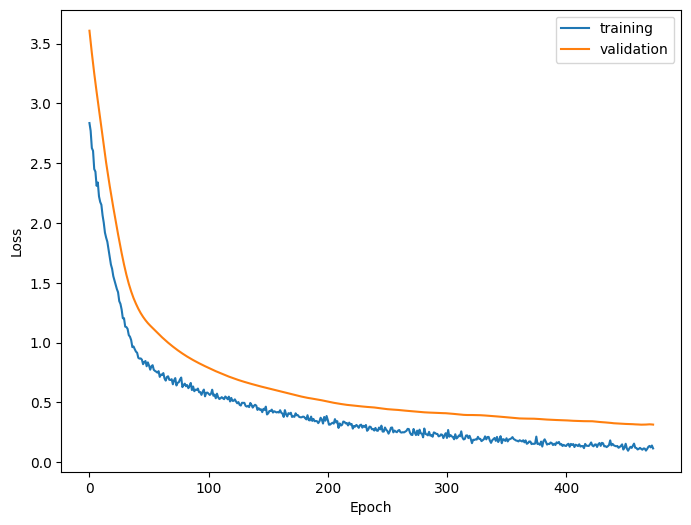

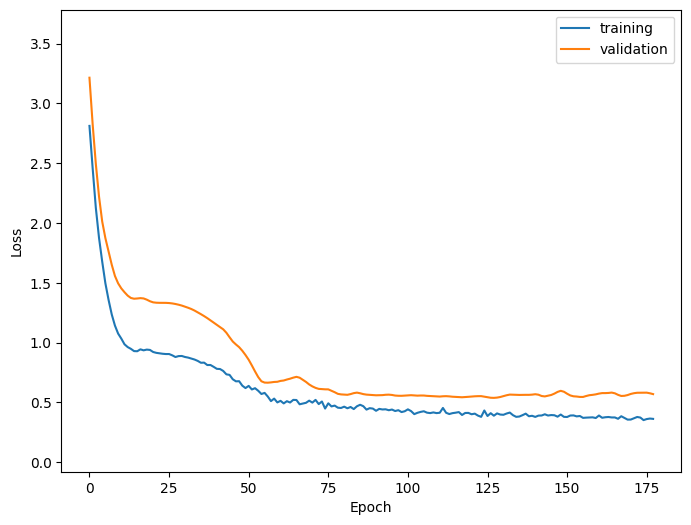

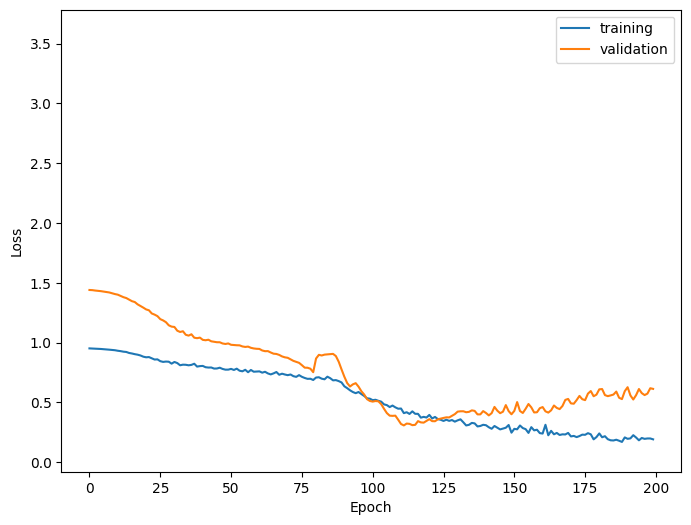

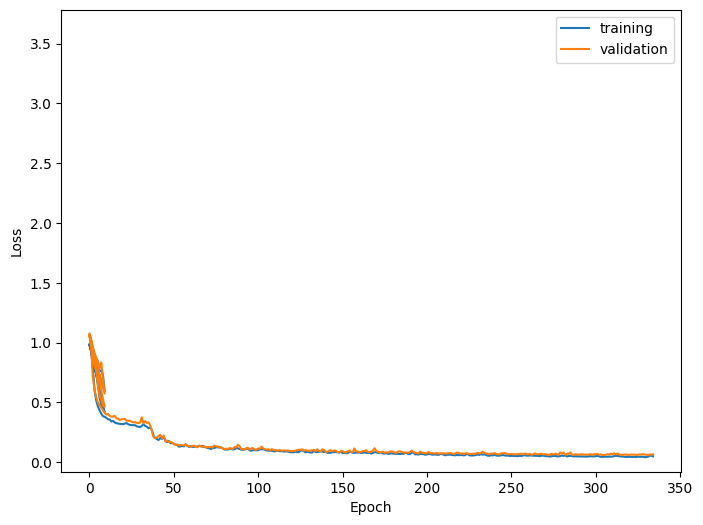

In [19]:
# load training history csv and plot

figure_path = "./figuresP3/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

history = pd.read_csv("./trainedModels/GMMB_PY/lapse/LSTM_LoCap_LowNoise_2000_layerFreezing/training_history.csv")
history_FT = pd.read_csv("./trainedModels/GMMB_PY/lapse/LSTM_LoCap_LowNoise_nolapse_2000_fineTuning/training_history.csv")
history_without = pd.read_csv("./trainedModels/GMMB_PY/lapse/LSTM_LoCap_LowNoise_2000/training_history_0001.csv")
history_extensive = pd.read_csv("./trainedModels/GMMB_PY/lapse/LSTM_LoCap_LowNoise_50000/training_history.csv")

plt.figure(figsize=(8, 6))
plt.plot(history["epoch"], history["loss"], label="training")
plt.plot(history["epoch"], history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("Layer Freezing")
plt.savefig(figure_path + "figure1d.png")

y_lim = plt.gca().get_ylim()

plt.figure(figsize=(8, 6))
plt.plot(history_FT["epoch"], history_FT["loss"], label="training")
plt.plot(history_FT["epoch"], history_FT["val_loss"], label="validation")
plt.ylim(y_lim)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("Fine Tuning")
plt.savefig(figure_path + "figure1c.png")

plt.figure(figsize=(8, 6))
plt.plot(history_without["epoch"], history_without["loss"], label="training")
plt.plot(history_without["epoch"], history_without["val_loss"], label="validation")
plt.ylim(y_lim)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("Without Transfer Learning")
plt.savefig(figure_path + "figure1b.png")

plt.figure(figsize=(8, 6))
plt.plot(history_extensive["epoch"], history_extensive["loss"], label="training")
plt.plot(history_extensive["epoch"], history_extensive["val_loss"], label="validation")
plt.ylim(y_lim)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("Extensive Training")
plt.savefig(figure_path + "figure1a.png")


In [22]:
model_LF = tf.keras.models.load_model("./trainedModels/GMMB_PY/lapse/LSTM_LoCap_LowNoise_2000_layerFreezing/trained_model.keras")
model_FT = tf.keras.models.load_model("./trainedModels/GMMB_PY/lapse/LSTM_LoCap_LowNoise_nolapse_2000_fineTuning/trained_model.keras")
model_WO = tf.keras.models.load_model("./trainedModels/GMMB_PY/lapse/LSTM_LoCap_LowNoise_2000/trained_model_0001.keras")
model_ET = tf.keras.models.load_model("./trainedModels/GMMB_PY/lapse/LSTM_LoCap_LowNoise_50000/trained_model.keras")

cwd = "../sim_VA/result/GMMB/lapse/"
Price = np.load(cwd + "outerScenarios_GMMB_RS_lapse.npy")
Loss = np.load(cwd + "hedgingLoss_GMMB_RS_100_lapse.npy")
Return = (Price[:, 1:] - Price[:, :-1]) / Price[:, :-1]

X_train, y_train, X_test, y_test, y_mean, y_std = preprocess.transform_data(Return, Loss, True, 0, 22, part=True, part_size=2000)

loss_true = np.load(cwd + "hedgingLoss_GMMB_RS_10000_lapse.npy")

X_true, y_true = preprocess.transform_data(Return, loss_true, False, 0, 22, y_mean=y_mean, y_std=y_std)

y_pred_LF = model_LF.predict(X_true).flatten()
y_pred_FT = model_FT.predict(X_true).flatten()
y_pred_WO = model_WO.predict(X_true).flatten()
y_pred_ET = model_ET.predict(X_true).flatten()

mse_LF = np.mean((y_true - y_pred_LF) ** 2)
mse_FT = np.mean((y_true - y_pred_FT) ** 2)
mse_WO = np.mean((y_true - y_pred_WO) ** 2)
mse_ET = np.mean((y_true - y_pred_ET) ** 2)

print(f"MSE Layer Freezing: {mse_LF}")
print(f"MSE Fine Tuning: {mse_FT}")
print(f"MSE Without: {mse_WO}")
print(f"MSE Extensive: {mse_ET}")


Data is split, training and test data has shape:
(2000, 240, 1) (2000,) (2000, 240, 1) (2000,)
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
MSE Layer Freezing: 0.30701522959258865
MSE Fine Tuning: 0.3622071580427137
MSE Without: 0.40833183269761575
MSE Extensive: 0.02210943638883051


In [33]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

def build_multiHead(X, num_heads=4,
                    recurrent_layer_size=(32, 4), dense_layer_size=32,
                    activation_func="ReLU",
                    lr=0.001, dropout=0.1, decay_rate=0.9):

    if activation_func == "ReLU":
        activation = tf.keras.activations.relu
    else:
        activation = tf.keras.activations.tanh

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                                 decay_steps=1000,
                                                                 decay_rate=decay_rate)
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    input = Input(shape=(X.shape[1], 1))

    shared = LSTM(units=recurrent_layer_size[0], activation=activation, return_sequences=True)(input)
    shared = LSTM(units=recurrent_layer_size[1], activation=activation, return_sequences=True)(shared)
    shared = Flatten()(shared)

    # Create heads dynamically
    outputs = []
    for i in range(num_heads):
        head = Dense(dense_layer_size, activation=tf.keras.activations.relu)(shared)
        head = Dropout(dropout)(head)
        head_output = Dense(1, activation='linear', name=f'head_{i+1}_output')(head)
        outputs.append(head_output)

    model = Model(inputs=input, outputs=outputs)

    losses = ['mean_squared_error'] * num_heads

    model.compile(optimizer=optimizer, loss=losses, metrics=['mean_squared_error']*num_heads)

    print(model.summary())

    return model

model = build_multiHead(X_train, num_heads=4,
                        recurrent_layer_size=(32, 4), dense_layer_size=8,
                        activation_func="ReLU",
                        lr=0.001, dropout=0.1, decay_rate=0.9)

train_labels = [np.random.random((5000, 1)) for _ in range(4)]  # Create labels for each head

model.fit(X_train, train_labels, epochs=100, batch_size=4096, validation_split=0.2, verbose=1)

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 240, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 240, 32)   │      4,352 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ (None, 240, 4)    │        592 │ lstm_39[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 960)       │          0 │ lstm_40[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 8)         │      7,688 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 8)         │      7,688 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 8)         │      7,688 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 8)         │      7,688 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 8)         │          0 │ dense_80[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_81          │ (None, 8)         │          0 │ dense_81[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_82          │ (None, 8)         │          0 │ dense_82[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 8)         │          0 │ dense_83[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_1_output       │ (None, 1)         │          9 │ dropout_80[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_2_output       │ (None, 1)         │          9 │ dropout_81[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_3_output       │ (None, 1)         │          9 │ dropout_82[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_4_output       │ (None, 1)         │          9 │ dropout_83[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,732 (139.58 KB)

 Trainable params: 35,732 (139.58 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - head_1_output_loss: 0.3333 - head_1_output_mean_squared_error: 0.3333 - head_2_output_loss: 0.3289 - head_2_output_mean_squared_error: 0.3289 - head_3_output_loss: 0.3326 - head_3_output_mean_squared_error: 0.3326 - head_4_output_loss: 0.3350 - head_4_output_mean_squared_error: 0.3350 - loss: 1.3297 - val_head_1_output_loss: 0.3229 - val_head_1_output_mean_squared_error: 0.3229 - val_head_2_output_loss: 0.3180 - val_head_2_output_mean_squared_error: 0.3180 - val_head_3_output_loss: 0.3473 - val_head_3_output_mean_squared_error: 0.3473 - val_head_4_output_loss: 0.3266 - val_head_4_output_mean_squared_error: 0.3266 - val_loss: 1.3149
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - head_1_output_loss: 0.3276 - head_1_output_mean_squared_error: 0.3276 - head_2_output_loss: 0.3235 - head_2_output_mean_squared_error: 0.3235 - head_3_output_loss: 0.3315 - head_3_output_mean_squared_error: 0.3315 - head_4_output_loss: 0.3311 - head_4_out

KeyboardInterrupt: 

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Define input shape (example: time steps = 10, features per step = 16)
input_shape = (10, 16)

# Input layer
inputs = Input(shape=input_shape)

# Shared LSTM layers
x = LSTM(64, return_sequences=True)(inputs)
x = LSTM(64)(x)

# Task 1: Regression (e.g., predicting a continuous variable)
task_1 = Dense(32, activation='relu')(x)
task_1_output = Dense(1, activation='linear', name='task_1_output')(task_1)

# Task 2: Classification (e.g., binary classification)
task_2 = Dense(32, activation='relu')(x)
task_2_output = Dense(1, activation='sigmoid', name='task_2_output')(task_2)

# Combine the tasks into the final model
model = Model(inputs=inputs, outputs=[task_1_output, task_2_output])

# Compile the model with different losses and metrics for each task
model.compile(
    optimizer='adam',
    loss={
        'task_1_output': 'mse',  # Mean Squared Error for regression task
        'task_2_output': 'binary_crossentropy'  # Binary Crossentropy for classification task
    },
    metrics={
        'task_1_output': 'mae',  # Mean Absolute Error for regression
        'task_2_output': 'accuracy'  # Accuracy for classification
    }
)

# Print the model summary
model.summary()

# Dummy training data (for illustration purposes)
import numpy as np

# Example input data
train_data = np.random.random((1000, 10, 16))  # 1000 samples, 10 time steps, 16 features

# Example target data for each task
train_labels_task_1 = np.random.random((1000, 1))  # Continuous values for regression
train_labels_task_2 = np.random.randint(0, 2, (1000, 1))  # Binary labels for classification

# Train the model
model.fit(
    train_data, 
    {'task_1_output': train_labels_task_1, 'task_2_output': train_labels_task_2},  # Targets for each task
    epochs=10, 
    batch_size=32
)


Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 10, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 10, 64)    │     20,736 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 64)        │     33,024 │ lstm_41[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 32)        │      2,080 │ lstm_42[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 32)        │      2,080 │ lstm_42[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_1_output       │ (None, 1)         │         33 │ dense_84[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_2_output       │ (None, 1)         │         33 │ dense_85[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,986 (226.51 KB)

 Trainable params: 57,986 (226.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.8353 - task_1_output_loss: 0.1419 - task_1_output_mae: 0.3103 - task_2_output_accuracy: 0.4972 - task_2_output_loss: 0.6934
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7852 - task_1_output_loss: 0.0893 - task_1_output_mae: 0.2622 - task_2_output_accuracy: 0.4975 - task_2_output_loss: 0.6959
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7811 - task_1_output_loss: 0.0865 - task_1_output_mae: 0.2561 - task_2_output_accuracy: 0.4921 - task_2_output_loss: 0.6946
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7878 - task_1_output_loss: 0.0931 - task_1_output_mae: 0.2653 - task_2_output_accuracy: 0.4752 - task_2_output_loss: 0.6948
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7837 - task_1_output_loss: 0.0899 - task_1_output_mae: 0.2629 - task_2_output_accuracy: 0.5199 - task_2_output_loss: 0.6938
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7805 - task_1_o